## Building a Neural-Network With Numpy and Math
Goal for this project is to gain an understanding of the inner workings of a neural network. To accomplish we will just using Numpy, without using any pre-built frameworks and the MNIST dataset from Kaggle.  
We will then test the model against a keras model to compare effectiveness

In [66]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('digit-recognizer/train.csv')

**Convert the dataset to a NumPy array and shuffled it to remove ordering bias.**

*Split the data into:*

Training set (all but first 1000 examples)

Validation set (first 1000 examples)

Transposed the data so each column represents one image.

Separated labels (Y) from pixel data (X).

Normalized pixel values by dividing by 255 to scale them to [0, 1].



In [67]:
data = np.array(data)
m, n = data.shape

np.random.shuffle(data) #shuffle to remove label bias

val_set = data[0:1000].T # First 1000 examples are validation set, transpose 

y_dev = val_set[0] #labels for 1000 validation examples (first row)
x_dev = val_set[1:n] #gets 784 pixel vals for each image (rows 1 to 784)
x_dev = x_dev/255 #Normalize pixel vals from 0-255 -> 0-1

dat_train = data[1000:m].T #training set
y_train = dat_train[0]
x_train = dat_train[1:n]
x_train = x_train / 255



Our NN will have a simple two‑layer architecture.  
Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28×28 input image. A hidden layer $a^{[1]}$ will have 10 units with **ReLU** activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with **softmax** activation.

---

### **Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$  
*Multiply the input matrix $X$ by the first‑layer weights $W^{[1]}$ and add the bias $b^{[1]}$ to get raw scores for each hidden neuron.*

$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$  
*Apply the ReLU function element‑wise: values $\le 0$ become 0, positives stay the same.  
The result $A^{[1]}$ is the hidden layer’s output.*

$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$  
*Feed the hidden activations into the second weight matrix, add the bias, and get one raw score per digit class.*

$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$  
*Softmax turns those scores into probabilities that sum to 1 for each image (column).*

---

### **Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$  
*Difference between predicted probabilities and the true one‑hot labels.*

$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$  
*Gradient of the loss with respect to second‑layer weights (average over $m$ examples).*

$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$  
*Gradient for the second‑layer biases.*

$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$  
*Back‑propagate the error to the hidden layer and gate it with ReLU’s derivative  
($g^{[1]\prime}(z)=1$ where $z>0$, else 0).*

$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$  
*Gradient of the loss with respect to first‑layer weights.*

$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$  
*Gradient for the first‑layer biases.*

---

### **Parameter updates**  (Gradient Descent)

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$  
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$  
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$  
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$  

*Subtract a small fraction ($\alpha$ = learning rate) of each gradient to nudge the parameters toward lower error.*

---

### **Vars and shapes**

Forward prop  

- $A^{[0]} = X$: 784 × m  
- $Z^{[1]} \sim A^{[1]}$: 10 × m  
- $W^{[1]}$: 10 × 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)  
- $B^{[1]}$: 10 × 1  
- $Z^{[2]} \sim A^{[2]}$: 10 × m  
- $W^{[1]}$: 10 × 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)  
- $B^{[2]}$: 10 × 1  

Backprop  

- $dZ^{[2]}$: 10 × m ($\sim A^{[2]}$)  
- $dW^{[2]}$: 10 × 10  
- $dB^{[2]}$: 10 × 1  
- $dZ^{[1]}$: 10 × m ($\sim A^{[1]}$)  
- $dW^{[1]}$: 10 × 10  
- $dB^{[1]}$: 10 × 1  


In [68]:
def init_params():
    w1 = np.random.randn(10, 784) * np.sqrt(2/784)
    b1 = np.zeros((10,1))
    w2 = np.random.randn(10, 10)  * np.sqrt(2/10)
    b2 = np.zeros((10,1))
    return w1, b1, w2, b2

def relu(z):
    return np.maximum(z,0)

def softmax(z):
    expZ = np.exp(z - np.max(z, axis=0, keepdims=True))    # stability
    return expZ / np.sum(expZ, axis=0, keepdims=True)

def forwardPropogation(w1,b1,w2,b2,x):
    z1 = w1.dot(x)+b1
    a1 = relu(z1)
    z2 = w2.dot(a1)+b2
    a2 = softmax(z2)
    return z1, a1, z2, a2

def derivRelu(z):
    return (z > 0).astype(float)

def one_hot(y):
    oneHotY= np.zeros((y.size, y.max()+1))
    oneHotY[np.arange(y.size), y] = 1
    oneHotY = oneHotY.T
    return oneHotY

def backward_propogation(z1,a1,z2,a2,w1,w2,x,y):
    oneHotY = one_hot(y)
    dz2 = a2 - oneHotY
    dw2 = (1 / m) * dz2.dot(a1.T)
    db2 = (1 / m) * np.sum(dz2, axis=1, keepdims=True)

    dz1 = w2.T.dot(dz2) * derivRelu(z1)
    dw1 = (1 / m) * dz1.dot(x.T)
    db1 = (1 / m) * np.sum(dz1, axis=1, keepdims=True)
    return dw1, db1, dw2, db2

def update_params(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha):
    w1 = w1-alpha *dw1
    b1 = b1- alpha *db1
    w2 = w2 - alpha *dw2
    b2 = b2 - alpha *db2
    return w1, b1, w2, b2


In [69]:
def get_predictions(a2):
    return np.argmax(a2,0)

def get_accuracy(pred, y):
    print(pred, y)
    return np.sum(pred == y)/y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forwardPropogation(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_propogation(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [70]:
# Output is: Iteration | [Predictions] | [true labels] | Accuracy
W1, b1, W2, b2 = gradient_descent(x_train, y_train, 0.10, 500)

Iteration:  0
[3 8 3 ... 2 2 4] [4 4 8 ... 0 6 2]
0.0788780487804878
Iteration:  10
[6 6 3 ... 3 6 4] [4 4 8 ... 0 6 2]
0.3513414634146341
Iteration:  20
[6 6 3 ... 0 6 4] [4 4 8 ... 0 6 2]
0.5562926829268293
Iteration:  30
[4 6 3 ... 0 6 2] [4 4 8 ... 0 6 2]
0.6510243902439025
Iteration:  40
[4 6 3 ... 0 6 2] [4 4 8 ... 0 6 2]
0.7051951219512195
Iteration:  50
[4 6 3 ... 0 6 2] [4 4 8 ... 0 6 2]
0.7360975609756097
Iteration:  60
[4 6 3 ... 0 6 2] [4 4 8 ... 0 6 2]
0.7628048780487805
Iteration:  70
[4 9 3 ... 0 6 2] [4 4 8 ... 0 6 2]
0.7839268292682927
Iteration:  80
[4 9 3 ... 0 6 2] [4 4 8 ... 0 6 2]
0.8033170731707318
Iteration:  90
[4 9 3 ... 0 6 2] [4 4 8 ... 0 6 2]
0.8191219512195121
Iteration:  100
[4 9 3 ... 0 6 2] [4 4 8 ... 0 6 2]
0.8311951219512195
Iteration:  110
[4 9 3 ... 0 6 2] [4 4 8 ... 0 6 2]
0.8407317073170731
Iteration:  120
[4 9 3 ... 0 6 2] [4 4 8 ... 0 6 2]
0.8489024390243902
Iteration:  130
[4 9 3 ... 0 6 2] [4 4 8 ... 0 6 2]
0.854609756097561
Iteration:  140
[4

In [71]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forwardPropogation(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = x_train[:, index, None]
    prediction = make_predictions(x_train[:, index, None], W1, b1, W2, b2)
    label = y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [4]
Label:  4


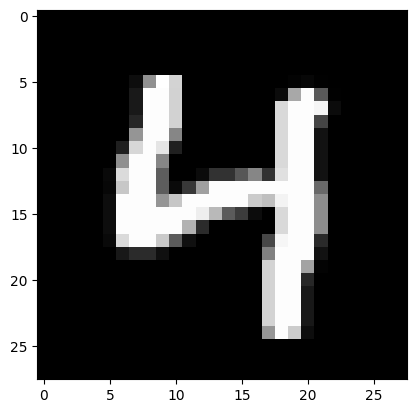

Prediction:  [9]
Label:  4


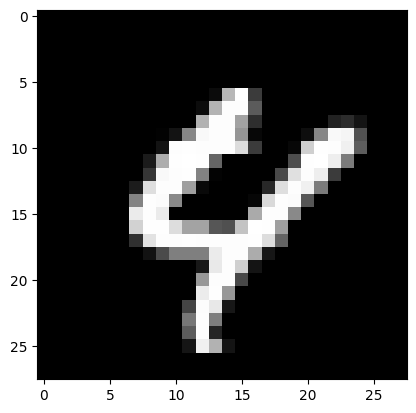

Prediction:  [8]
Label:  8


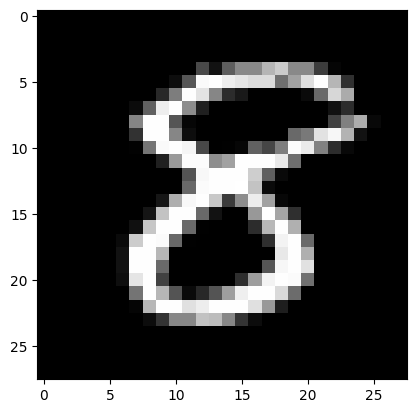

Prediction:  [3]
Label:  3


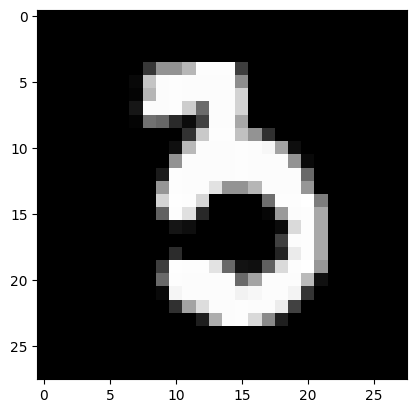

In [72]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)